# BSc Thesis: Evaluation of Decision Tree and Random Forest Classifiers in the Finance Domain
Thesis aiming to evaluate the application of decision tree and random forest classifiers within the financial domain

## Table of Contents
0. Preparation
1. Data Preparation Stage
2. Hyperparameter Tuning
3. Evaluation Stage
4. Visualisation
5. Final Evaluations

# 0 | Preparation
- Import libraries and define constant variables

### Imports

In [34]:
# Data manipulation and arrays
import pandas as pd
import numpy as np

# Machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn import metrics

# Plottig
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

### Constant variables

In [35]:
# Define filenames for technology stock .CSV datasets
AAPL_DATA = "Datasets/Kaggle_SnP500_AAPL_2013-2018.csv"
AMZN_DATA = "Datasets/Kaggle_SnP500_AMZN_2013-2018.csv"
CSCO_DATA = "Datasets/Kaggle_SnP500_CSCO_2013-2018.csv"
GE_DATA = "Datasets/Kaggle_SnP500_GE_2013-2018.csv"
GOOGL_DATA = "Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv"
HP_DATA = "Datasets/Kaggle_SnP500_HP_2013-2018.csv"
IBM_DATA = "Datasets/Kaggle_SnP500_IBM_2013-2018.csv"
INTC_DATA = "Datasets/Kaggle_SnP500_INTC_2013-2018.csv"
MSFT_DATA = "Datasets/Kaggle_SnP500_MSFT_2013-2018.csv"
WU_DATA = "Datasets/Kaggle_SnP500_WU_2013-2018.csv"
XRX_DATA = "Datasets/Kaggle_SnP500_XRX_2013-2018.csv"
TECH_GROUP = [AAPL_DATA, AMZN_DATA, CSCO_DATA, GE_DATA, GOOGL_DATA, HP_DATA, IBM_DATA, INTC_DATA, MSFT_DATA, WU_DATA, XRX_DATA]

# Define time horizons to compare classification results for 1-day to 1-year predictions (approx. trading days)
TIME_HORIZONS = [1, 5, 10, 20, 65, 250]

# Make code reproducible by seeding random states
RANDOM_SEED = 42

# 1 | Data Preparation Stage
- Load data and adjust columns as needed, extract features for technical analysis, define classes, detect anomalies
- No feature selection needed as embedded in Decision Trees (DT) and Random Forests (RF)
- These functions will later be invoked in the Final Evaluations stage

## 1.1 | Load Datasets
- For an apples-to-apples comparison, technology companies are analyzed (idea: companies/stocks within an industry have similar drivers)
- Selected stocks differ in price trends (upward- vs constant- vs downward trend)

In [70]:
def load_OHLC_data(filename=MSFT_DATA, time_horizons=TIME_HORIZONS):
    """
    Loads basic stock data (date, name, open, high, low, close) from a given .CSV file and returns a corresponding DataFrame.
    Unnecessary categorical columns are dropped, and necessary columns (e.g. month as number) are added.
    """
    try:
        df = pd.read_csv(filename)
        if SAVE_FIG is True:
            # Visualize loaded time series data if applicable
            df["date"] = pd.to_datetime(df["date"])
            df.plot(x="date", y="close", figsize=(12,6), legend=None)
            plt.xlabel("Time [Year]")
            plt.ylabel("Price [daily closing price in USD]")
            plt.title(df["Name"][0] + "-Stock Data 2013 to 2018");
            plt.savefig("./Plots/Stock-Price-Plots/" + df["Name"][0] + "-Stock-Price-Plot.jpeg")
        
        # Calculate base column for later class: future return of stock over given time horizon (e.g. this week's Monday to next week's Monday)
        for horizon in time_horizons:
            df["return_future_" + str(horizon) + "d"] = (df["close"].shift(-1*horizon)/df["close"])-1
        
        # Convert date to numerical month to possibly detect cyclicality (e.g. christmas effect) in time series
        df["month"] = df["date"].astype("datetime64[ns]").dt.month
        
        if VERBOSE is True:
            print("load_OHLC_data() -> Loaded DataFrame has the following columns:")
            for col in df:
                print("Column \'" + col + "\' with type", type(df[col][0]), ", e.g.", df[col][0])
            print("load_OHLC_data() -> df.head():")
            print(df.head())
            
        return df
    except:
        print("load_OHLC_data() -> Error, failed to find or load OHLC data from file with name \'"
              + filename + "\'. Please provide well-formed CSV file with OHLC stock data")

In [37]:
# dfs_TECH_GROUP = []
# for stock in TECH_GROUP:
#     dfs_TECH_GROUP.append(load_OHLC_data(stock))

## 1.2 | Extract Features
- Common metrics for technical analysis are calculated and added as features
- Suitable TA libary for more technical features: https://github.com/bukosabino/ta

In [73]:
def extract_OHLC_features(df, time_horizons=TIME_HORIZONS):
    """
    Extract common technical stock analysis features from given OHLC stock data for distinct time horizons
    """
    # Calculate technical features for each time horizon
    for horizon in time_horizons:
        # Past return of stock over given time horizon (e.g. last week's Monday to this week's Monday)
        df["return_past_" + str(horizon) + "d"] = (df["close"]/df["close"].shift(horizon))-1
        
        # Implied volatility measured by standard deviation
        df["volatility_" + str(horizon) + "d"] = df["close"].rolling(horizon).std()
        
        # Moving averages (ma)
        df["ma_" + str(horizon) + "d"] = df["close"].rolling(horizon).mean()
        
        # Momentum (absolute change in price over past horizon)
        df["momentum_" + str(horizon) + "d"] = df["close"].diff(horizon)
        
        # If needed, use TA library for: ewma, #Pivot Points, Bollinger bands, Supports and Resistances, etc.
    
    # OHLC average is used for stock price average of a given day
    df["ohlc_avg"] = df[["open", "high", "low", "close"]].mean(axis=1)
    if VERBOSE is True:
        print("extract_OHLC_features() -> extracted features, columns are now: " + str(df.columns))
    # Replace NaNs with zeroes
    df = df.fillna(value=0)
    
    return df

In [39]:
# for df in dfs_TECH_GROUP:
#     df = extract_OHLC_features(df, TIME_HORIZONS)

## 1.3 | Anomaly Detection
- Anomaly defined as: ABS(return_past_1d) > threshold=5% (default)
- Such anomalies (5% threshold) occur in about 1.4% of instances for seven tech stock datasets

In [40]:
def detect_anomalies(df, threshold=0.05):
    """
    Iterates through the DataFrame and prints out all dates where 1-day-return is greater than threshold=5% (default)
    """
    if VERBOSE is True:
        print("Detecting anomalies where abs(1-day-return)>" + str(threshold*100) + " % for " + df["Name"][0])

    anomaly_counter = 0
    for i in range(len(df)):
        x = df["return_past_1d"][i]
        d = df["date"][i]
        if (abs(x) > threshold):
            anomaly_counter = anomaly_counter + 1
            if VERBOSE is True:
                print("Anomaly: 1-day-return of " + str(round(x * 100, 2)) + "% on " + d.strftime("%A, %d.%m.%Y"))
    
    return anomaly_counter

In [41]:
# anomaly_counter = 0
# for df in dfs_TECH_GROUP:
#     anomaly_counter = anomaly_counter + detect_anomalies(df, threshold=0.05)

# print("anomaly_counter=" + str(anomaly_counter) + ", or " + str(round(anomaly_counter*100/(len(TECH_GROUP)*len(dfs_TECH_GROUP[0])), 2)) + "% of instances")

## 1.4 | Define classes
- This notebook evaluates classifiers for stock recommendation where class indicates if stock goes up (class=1) or down (class=0) in given time horizon
- Base columns used to determine these classes are subsequently removed to prevent illegal, future-peeking features

In [72]:
def define_classes(df, time_horizons=TIME_HORIZONS):
    """
    Create target column in df: 1 means 'Yes, investor should buy stock', 0 means 'No, investor should not buy stock'.
    The assumed trading strategy here is, that the investor buy the stock on a given date and sells it at the end of horizon.
    Also removes illegal (future-peeking) columns
    """
    for horizon in time_horizons:
        base_column_name = "return_future_" + str(horizon) + "d"
        class_name = "class_" + str(horizon) + "d"
        
        # 1. Add class column to dataframe
        if class_name not in df.columns:
            df[class_name] = np.where(df[base_column_name] > 0, 1, 0)
        # 2. Remove base column as it would be an illegal (future-peeking) feature
        if base_column_name in df.columns:
            df = df.drop(columns=[base_column_name])
    
    return df

In [43]:
# for i in range(0, len(dfs_TECH_GROUP)):
#     dfs_TECH_GROUP[i] = define_classes(dfs_TECH_GROUP[i])

## 1.5 | Check class balance

In [44]:
def check_class_balance(df, time_horizons=TIME_HORIZONS):
    """
    Plots class histogram for each time horizon provided
    """
    for horizon in time_horizons:
        class_name = "class_" + str(horizon) + "d"
        if VERBOSE is True:
            print(df[class_name].value_counts())
        
        if SAVE_FIG is True:
            plt.figure()
            df[class_name].hist()
            plt.xlabel("Klasse")
            plt.ylabel("Haeufigkeit")
            plt.title(df["Name"][0] + "-Klassen-Histogramm-" + str(horizon) + "d")
            plt.savefig("./Plots/Class-Balance-Check/" + df["Name"][0] + "-Class-Balance-Histogram-" + str(horizon) + "d.jpeg")
            plt.close()

In [45]:
# for i in range(0, len(dfs_TECH_GROUP)):
#     check_class_balance(dfs_TECH_GROUP[i])

## 1.6 | Define training and test sets
- Seed RandomState-s uniformly to make algorithms reproducible

In [74]:
def train_test_split_data(df, train_size=0.7, time_horizons=TIME_HORIZONS):
    """
    Generates training and testing set from a given DataFrame dataset.
    Assumes last COUNT(time_horizons) column(s) in DataFrame are classes, others are features
    """
    # 1. Remove non-numerical features and save final feature names (e.g. for later matching to feature importances)
    df = df.drop(columns=["Name", "date"])
    global g_feature_names
    g_feature_names = df.columns.values.tolist()
    
    # 2. Split DataFrame into features (X) and target (y)
    X = df.iloc[:,:-1*len(time_horizons)]
    y = df.iloc[:,-1*len(time_horizons):]
    
    # 3. Use first (in same chronological order as time series) 70% to train and last 30% to test
    split_index = int(len(X) * train_size)
    if VERBOSE is True:
        print("train_test_split_data() -> Split ist bei Index " + str(split_index) + " von " + str(len(X)))
    
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    return X_train, X_test, y_train, y_test

## 1.7 | Master function for loading data, extracting features and, if applicable, splitting data (train vs test)

In [47]:
def generate_train_test_data(filename=MSFT_DATA, extract_features=True, horizon_index=2, train_size=0.7):
    """
    Serves as a one-stop-shop function for data loading incl. preparation so that classifier only relies on this single function (and not multiple functions) 
    """
    # 1. Load data from .CSV (1.1)
    df = load_OHLC_data(filename)
    stock_ticker = df["Name"][0]
    if VERBOSE is True:
        print("generate_train_test_data() -> loaded " + str(stock_ticker))
    
    # 2. Extract features if applicable (1.2)
    if extract_features is True:
        df = extract_OHLC_features(df)
    
    # Detect anomalies (1.3) skipped
    # 3. Define classes (1.4)
    df = define_classes(df)
    
    # Check class balance (1.5) skipped
    # 4. Split data into training and testing samples if applicable (or get 100% as training data to later apply CV) (1.6)
    X_train, X_test, y_train, y_test = train_test_split_data(df, train_size=train_size)
    
    # 5. Return one single class series, depending on the horizon_index provided
    y_train = y_train[y_train.columns[horizon_index]]
    y_test = y_test[y_test.columns[horizon_index]]
    
    return stock_ticker, X_train, X_test, y_train, y_test

In [48]:
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(extract_features=False)
# print(X_train.columns)
# print(y_train.name)
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(extract_features=True)
# print(X_train.columns)
# print(y_train.name)

# 2 | Hyperparameter Tuning
- Define tuninig functions for decision trees and random forests
- These functions will later be invoked in the Final Evaluations stage

## 2.1 | Hyperparameter tuning a decision tree

In [49]:
def tune_decision_tree(dt, X, y):
    """
    Returns decision tree with best hyperparameters (out of all grid combinations)
    """
    # 1. Create grid with all values that should be considered as hyperparameters
    param_grid = {"max_depth": [3, 5, 7, 9, 11, 13, 15, 29],
                      "max_features": [3, 5, 9 ,11, 13, 15, 29],
                      "min_samples_split": [3, 5, 7, 10, 15, 29],
                      "min_samples_leaf": [1, 3, 5, 7, 11, 29]}
    
    # 2. Run GridSearch. Randomized version is much faster with a small loss in optimality
    tscv = TimeSeriesSplit(n_splits=10)
    # grid_search = GridSearchCV(dt, param_grid, cv=tscv)
    grid_search = RandomizedSearchCV(dt, param_grid, cv=tscv, random_state=RANDOM_SEED)
    grid_search.fit(X, y)

    if VERBOSE is True:
        print("tune_decision_tree() -> done.")
        print("tune_decision_tree() -> best score: " + str(grid_search.best_score_ ))
        print("tune_decision_tree() -> best params: " + str(grid_search.best_params_ ))
        print("tune_decision_tree() -> best estimator: " + str(grid_search.best_estimator_))
    
    return grid_search.best_estimator_

In [50]:
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(AAPL_DATA, horizon_index=2, train_size=1)
# clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
# dt_new = tune_decision_tree(clf, X_train, y_train)
# print("dt_new ist: " + str(dt_new))

## 2.2 | Hyperparameter tuning a random forest

In [75]:
def tune_random_forest(rf, X, y):
    """
    Returns random forest with best hyperparameters (out of all grid combinations)
    """
    # 1. Create grid with all values that should be considered as hyperparameters
    param_grid = {"max_depth": [3, 7, 17],
                        "min_samples_leaf": [3, 13, 23]}
#     rf.set_params(n_estimators=100) # Set n_estimators afterwards to reduce searching time

    # 2. Run GridSearch. Randomized version is much faster with a small loss in optimality
    tscv = TimeSeriesSplit(n_splits=10)
    # grid_search = GridSearchCV(dt, param_grid, cv=tscv)
    grid_search = RandomizedSearchCV(rf, param_grid, cv=tscv, random_state=RANDOM_SEED, n_iter=9)
    grid_search.fit(X, y)

    if VERBOSE is True:
        print("tune_random_forest() -> done.")
        print("tune_random_forest() -> best score: " + str(grid_search.best_score_ ))
        print("tune_random_forest() -> best params: " + str(grid_search.best_params_ ))
        print("tune_random_forest() -> best estimator: " + str(grid_search.best_estimator_))
    
    return grid_search.best_estimator_

In [52]:
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(AAPL_DATA, horizon_index=2, train_size=1)
# clf = RandomForestClassifier(n_estimators=5, random_state=RANDOM_SEED)
# rf_new = tune_random_forest(clf, X_train, y_train)
# print("rf_new ist: " + str(rf_new))

# 3 | Evaluation Stage
- Define functions for building confusion matrixes, calculating performance metrics, determining feature importances and plotting findings
- These functions will later be invoked in the Final Evaluations stage

## 3.1 | Apply time series cross validation (TSCV)

In [80]:
def apply_tscv(clf, X, y, return_predictions=False, tuning=False, importances_only=False):
    """
    Uses time series cross validation to calculate feature importances, raw metrics (actuals, predicteds) or aggregated metrics (accuracy etc.)
    """
    # 0. Instantiate TSCV and result variables
    tscv = TimeSeriesSplit(n_splits=10)
    train_sizes_manual = []
    test_sizes_manual = []
    train_scores_manual = []
    test_scores_manual = []
    y_actuals_raw = []
    y_predicteds_raw = []
    
    # 1. Manually apply epoch indices from TSCV (as learning_curve() does not seem to work with TSCV, e.g. train_sizes is wrong)
    epoch_counter = 0
    for train_index, test_index in tscv.split(X):
        # 2. Define indizes for training and testing
        first_train_index = 0
        last_train_index = train_index[-1]
        first_test_index = test_index[0]
        last_test_index = test_index[-1]
        
        global g_current_tscv_epoch
        g_current_tscv_epoch = epoch_counter
        if VERBOSE is True:
            print("apply_tscv() -> epoch=" + str(epoch_counter) + ", train on indices=[" + str(first_train_index) + 
                  ", " + str(last_train_index) + "], test on indices=[" + str(first_test_index) + ", " + str(last_test_index) +
                  "], " + "i.e. train_size=", len(train_index), ", test_size=", len(test_index))
        train_sizes_manual.extend([len(train_index)])
        test_sizes_manual.extend([len(test_index)])
        
        # 3. Create training and test sets
        X_train = X[first_train_index:last_train_index]
        X_test = X[first_test_index:last_test_index]
        y_train = y[first_train_index:last_train_index]
        y_test = y[first_test_index:last_test_index]
        
        # 4. Delegate calculation of feature importances, raw metrics (actuals, predicteds) or aggregated metrics (accuracy)
        if importances_only is True:
            calculate_feature_importances(clf, X_train, X_test, y_train, y_test, tuning=tuning)
        elif return_predictions is True: # return raw metrics (actuals, predicteds)
            y_actual, y_predicted = get_actual_and_predicted_ys(clf, X_train, X_test, y_train, y_test, tuning=tuning)
            # 5a. Add raw values to return list
            y_actuals_raw.extend(y_actual)
            y_predicteds_raw.extend(y_predicted)
        else: # return aggregated metrics (accuracy)
            train_score = calculate_accuracy(clf, X_train, X_train, y_train, y_train, tuning=False)
            test_score = calculate_accuracy(clf, X_train, X_test, y_train, y_test, tuning=False)
            # 5b. Add new scores to return list
            train_scores_manual.extend([train_score])
            test_scores_manual.extend([test_score])
        
        # 6. Increase epoch counter  
        epoch_counter = epoch_counter + 1
    
    if importances_only is True:
        return
    elif return_predictions is True:
        return y_actuals_raw, y_predicteds_raw
    else:
        return train_sizes_manual, train_scores_manual, test_scores_manual

## 3.2 | Calculate predictions

In [54]:
def get_actual_and_predicted_ys(clf, X_train, X_test, y_train, y_test, tuning=False):
    """
    Generate predictions on given test set for further analysis (confusion metrics, accuracy, plotting, etc.)
    """
    if not isinstance(y_train, pd.Series) or not isinstance(y_test, pd.Series):
        print("get_actual_and_predicted_ys() -> y-DataFrames must have 1 column only.")
        return -1
    
    # 1. Fit and, if applicable, tune classifier to predict y-s
    if tuning is True and isinstance(clf, type(DecisionTreeClassifier())):
        clf = tune_decision_tree(clf, X_train, y_train)
    elif tuning is True and isinstance(clf, type(RandomForestClassifier())):
        clf = tune_random_forest(clf, X_train, y_train)
        clf.set_params(n_estimators=100) # set n_estimators after GridSearch to reduce searching time
    else:
        clf.fit(X_train, y_train)
    
    # 2. Return actual and predicted classes on test set
    y_actual = y_test
    y_predicted = clf.predict(X_test)
    
    return y_actual, y_predicted

## 3.3 | Calculate feature importances

In [81]:
def calculate_feature_importances(clf, X_train, X_test, y_train, y_test, tuning=False):
    """
    Calculates feature importances and, if applicable, plots top10 features
    """
    if not isinstance(y_train, pd.Series) or not isinstance(y_test, pd.Series):
        print("calculate_feature_importances() -> y-DataFrames must have 1 column only.")
        return -1
    
    # 1. Fit and, if applicable, tune classifier to predict y-s
    if tuning is True and isinstance(clf, type(DecisionTreeClassifier())):
        clf = tune_decision_tree(clf, X_train, y_train)
    elif tuning is True and isinstance(clf, type(RandomForestClassifier())):
        clf = tune_random_forest(clf, X_train, y_train)
        clf.set_params(n_estimators=100) # set n_estimators after GridSearch to reduce searching time
    else:
        clf.fit(X_train, y_train)
    
    # 2. Find and, if applicable, plot feature importances
    feature_importances = clf.feature_importances_
    global g_feature_importances # allow for global averaging (e.g. per horizon across all epochs)
    g_feature_importances.append(feature_importances)

    # 3. Find the top-10 features by importance
    feature_ranking_indicies = np.argsort(feature_importances)
    top10_features_indices = feature_ranking_indicies[-10:]
    if VERBOSE is True:
        print("calculate_feature_importances() -> Top1 feature:" + str(g_feature_names[top10_features_indices[-1]]) + " ->" + str(feature_importances[top10_features_indices[-1]]))
        print("calculate_feature_importances() -> Top2 feature:" + str(g_feature_names[top10_features_indices[-2]]) + " ->" + str(feature_importances[top10_features_indices[-2]]))
        print("calculate_feature_importances() -> Top3 feature:" + str(g_feature_names[top10_features_indices[-3]]) + " ->" + str(feature_importances[top10_features_indices[-3]]))

    # 4. Plot top10 feature importances in horizontal bars
    fig = plt.figure()
    plt.title("Einflussgrade der Features, " + str(g_classifier) + ", AAPL")
    plt.barh(y=[g_feature_names[i] for i in top10_features_indices], width=[feature_importances[i] for i in top10_features_indices])
    fig.tight_layout()
    if SAVE_FIG is True:
        plt.savefig("./Plots/" + str(g_plot_folder) + "/Top10Importances-" + str(g_classifier) + "-HorizonIndex" + str(g_horizon_index) + 
                    "-Epoch" + str(g_current_tscv_epoch)+ "-" + str(g_stock_ticker) + ".jpeg")
    plt.close()
    
    return

## 3.4 | Calculate accuracy

In [82]:
def calculate_accuracy(clf, X_train, X_test, y_train, y_test, tuning=False):
    """
    Calculates accuracy of non-tuned or tuned classifier
    """
    if not isinstance(y_train, pd.Series) or not isinstance(y_test, pd.Series):
        print("calculate_accuracy() -> y-DataFrames must have 1 column only.")
        return -1
    
    # 1. Fit and, if applicable, tune classifier to predict y-s
    if tuning is True and isinstance(clf, type(DecisionTreeClassifier())):
        clf = tune_decision_tree(clf, X_train, y_train)
    elif tuning is True and isinstance(clf, type(RandomForestClassifier())):
        clf = tune_random_forest(clf, X_train, y_train)
        clf.set_params(n_estimators=100) # set n_estimators after GridSearch to reduce searching time
    else:
        clf.fit(X_train, y_train)
    
    # 2. Calculate and return accuracy
    y_actual = y_test
    y_predicted = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_actual, y_predicted)
    
    return accuracy

## 3.5 | Calculate confusion metrics and, if applicable, plot confusion matrix

In [89]:
def calculate_confusion_metrics(y_actual, y_predicted):
    """
    Calculates precision, recall and f-measure and, if applicable, plots confusion matrix
    """
    # 1. Calculate confusion metrics
    precision = metrics.precision_score(y_actual, y_predicted) if (1 in y_predicted and 1 in y_actual) else -1
    recall = metrics.recall_score(y_actual, y_predicted) if (1 in y_predicted and 1 in y_actual) else -1
    f_measure = metrics.f1_score(y_actual, y_predicted) if (precision > 0 or recall >0) else -1
    if VERBOSE is True:
        print("calculate_confusion_metrics() -> Result on stock=" + str(g_stock_ticker) + " is precision=" 
              + str(round(precision, 3)) + ", recall=" + str(round(recall, 3)) + ", f_measure=" + str(round(f_measure, 3)))
    
    # 2. Plot confusion matrix via Seaborn if applicable
    confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
    fig, ax = plt.subplots()
    sns_ax = sns.heatmap(confusion_matrix, annot=True, annot_kws={'size':15}, fmt='g', cmap=plt.cm.Blues, cbar=False, square=True)
    sns_ax.invert_yaxis()
    sns_ax.invert_xaxis()
    ax.set(title= str(g_classifier) + ", " + str(g_stock_ticker) + ", Horizont-Index=" + str(g_horizon_index), ylabel="Korrekte Klasse", xlabel="Vorhergesagte Klasse")
    if SAVE_FIG is True:
        plt.savefig("./Plots/" + str(g_plot_folder) + "/ConfusionMatrix-" + str(g_classifier) + "-HorizonIndex" + str(g_horizon_index) + "-" + str(g_stock_ticker) + ".jpeg")
#     plt.close()
    
    return precision, recall, f_measure

# 4 | Visualization
- Define plotting functions

## 4.1 | Plot acuracy curve on train vs test data
- E.g. for different max_depth-s of decision tree
- Measure accuracy by TimeSeriesSplit

In [58]:
def plot_tscv_curve(clf, title, X, y):
    """
    Plots the accuracies on training and testing set for given classifier using Time Series Cross Validation
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ylim(0.00, 1.05)
    
    # 1. Apply Time Series CV to given data
    train_sizes_manual, train_scores_manual, test_scores_manual = apply_tscv(clf, X, y)
    
    # 2. Plot data points for training and testing
    if SAVE_FIG is True:
        plt.plot(train_sizes_manual, train_scores_manual, 'o-', color="r", label="Training")
        plt.plot(train_sizes_manual, test_scores_manual, 'o-', color="g", label="Test")
        mean_test_acc = [np.mean(test_scores_manual)]*len(test_scores_manual)
        plt.plot(train_sizes_manual, mean_test_acc, '--', color="g", label="Mean")
        plt.text(0.5, 0.01, "Mean=" + str(round(np.mean(test_scores_manual), 3)), size="15", weight="bold", 
                 horizontalalignment="center", verticalalignment="bottom", transform=ax.transAxes)
        plt.xlabel("Anzahl Trainingsinstanzen")
        plt.ylabel("Treffergenauigkeit")
        plt.title(title)
        plt.grid()
        plt.legend(loc=4)
        plt.savefig("./Plots/" + str(g_plot_folder) + "/Plot-" + title.replace(" ", "") + ".jpeg")
    
    # 3. Return results for plotting results in master diagram with other clf's results
    return train_sizes_manual, train_scores_manual, test_scores_manual

# 5 | Final Evaluations
- In the following, above functions will be called on different datasets in order to evaluate classifiers (Dummy, DT, RF) in different settings
 
## 5.0 | Evaluation settings
- For flexible switching of settings (model, toggle feature extraction & tuning, etc.), the following cell serves as the single point of truth that all below functions are based on

In [115]:
evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED) # DummyClassifier(RANDOM_SEED) vs DecisionTreeClassifier(RANDOM_SEED) vs RandomForestClassifier(RANDOM_SEED)
evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Which time horizon INDICES should be applied? E.g. list(range(0, len(TIME_HORIZONS))) for all horizon INDICES
use_feature_extraction = True # Extract features with technical analysis? True vs False
use_tuning = False # Tune hyperparameters of evaluation_model? True vs False

# Define verbosity
VERBOSE = False

# Centrally define if figures should be saved to ./plots/
SAVE_FIG = False

### Introduce global variables for easy plotting and easy averages across models/horizons/etc.

In [113]:
# These global strings should be set be the user. Will be used in .savefig() calls
g_classifier = "DT" # This string will be included in the plot filenames, e.g. "Tuned RF", "RF", "Dummy Classifier", etc.
g_plot_folder = "Feature-Importances-TBD" # Which subfolder of ./Plots is most suitable for planned plots? e.g. "Feature-Importances-DT"

# These global variables are set programatically and do NOT need to be set in advance by the user. Useful for global calculations (e.g. averages)
g_horizon_index = None # Will be included in the plot filenames, e.g. 2
g_stock_ticker = None # Will be included in the plot filenames, e.g. "AAPL"
g_feature_names = None # Useful for accessing feature names at any point at any time, e.g. when calculating feature importances
g_current_tscv_epoch = None # Will be included in the plot filenames, e.g. 3
g_feature_importances = [] # Useful for averaging feature importances independ of loop structures, e.g. average per horizon across all epochs

### Announce current settings ahead of evaluations

In [112]:
def announce_eval_settings():
    """
    Prints out key information about current evaluation settings
    """
    print("announce_eval_settings() -> g_classifier=" + str(g_classifier) + " with type=" + str(type(evaluation_model)))
    print("announce_eval_settings() -> g_plot_folder=" + str(g_plot_folder))
    print("announce_eval_settings() -> use_feature_extraction=" + str(use_feature_extraction) + ", use_tuning=" + str(use_tuning))
    print("announce_eval_settings() -> evaluation_horizons_indices=" + str(evaluation_horizons_indices))
    print("announce_eval_settings() -> SAVE_FIG=" + str(SAVE_FIG) + ", VERBOSE=" + str(VERBOSE))

## 5.1 | Get confusion metrics via TSCV
- Apply time series cross validation (tscv) to calculate confusion metrics for a given classifier on given stock for each time horizon

In [110]:
def get_tscv_confusion_metrics(clf):
    """
    Calculates confusion metrics for each stock (n=11) and for each horizon (n=6) for a total of 66 combinations plus TECH GROUP average
    """
    announce_eval_settings()
    # 0. Store interim results for later averaging across datasets
    y_act_TechGroup = [[] for h in range(0, len(TIME_HORIZONS))]
    y_pred_TechGroup = [[] for h in range(0, len(TIME_HORIZONS))]
    stock_ticker = None
    
    # 1. Load and loop over stock datasets
    for stock in [AAPL_DATA]:# TECH_GROUP:
        print("get_tscv_results() -> Stock=" + str(stock))
        
        # 2. Loop over prediction horizons
        for horizon in evaluation_horizons_indices:
            global g_horizon_index # make current horizon index accessible globally for .savefig()s
            g_horizon_index = str(horizon)
            
            # 3. Load data for current stock-horizon combination. Train_size=100% because train-test splits will be executed by TSCV function
            stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename=stock, extract_features=use_feature_extraction, horizon_index=horizon, train_size=1)
            if horizon == 0: # make current stock ticker index accessible globally for .savefig()s
                global g_stock_ticker 
                g_stock_ticker = str(stock_ticker)
            
            # 4. Get all TSCV predictions for confusion matrix and remember them for later averaging across all stocks
            y_act, y_pred = apply_tscv(clf, X_train, y_train, return_predictions=True, tuning=use_tuning, importances_only=False)
            y_act_TechGroup[horizon].extend(y_act)
            y_pred_TechGroup[horizon].extend(y_pred)

            # 5. Create confusion matrices and save figures if applicable
            precision, recall, f_measure = calculate_confusion_metrics(y_act, y_pred)
        
    print("get_tscv_confusion_metrics() -> Stock=Tech Group Average")
    g_stock_ticker = str("Tech-Group-AVG")
    for horizon in  range(0, len(TIME_HORIZONS)):
        g_horizon_index = str(horizon)
        precision, recall, f_measure = calculate_confusion_metrics(y_act_TechGroup[horizon], y_pred_TechGroup[horizon])
    
    return

announce_eval_settings() -> g_classifier=DT with type=<class 'sklearn.tree.tree.DecisionTreeClassifier'>
announce_eval_settings() -> g_plot_folder=Feature-Importances-TBD
announce_eval_settings() -> use_feature_extraction=True, use_tuning=False
announce_eval_settings() -> evaluation_horizons_indices=[0, 1, 2, 3, 4, 5]
announce_eval_settings() -> SAVE_FIG=False, VERBOSE=False
get_tscv_results() -> Stock=Datasets/Kaggle_SnP500_AAPL_2013-2018.csv
get_tscv_confusion_metrics() -> Stock=Tech Group Average


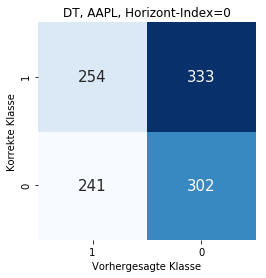

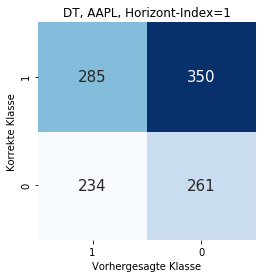

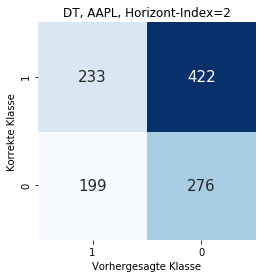

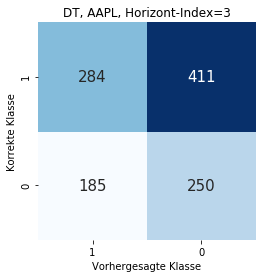

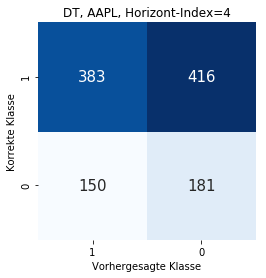

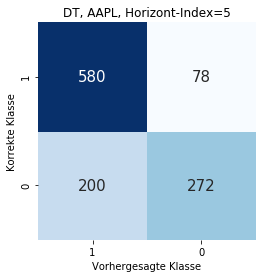

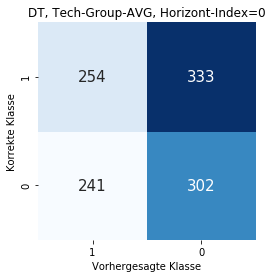

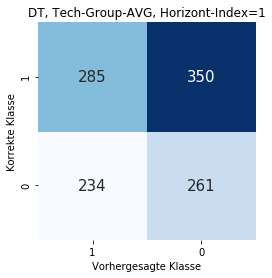

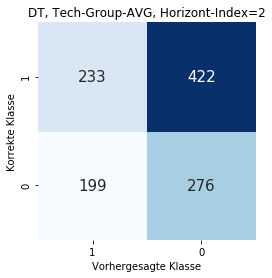

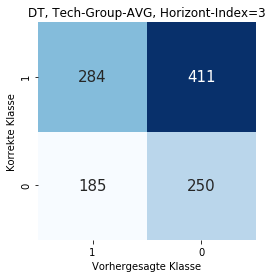

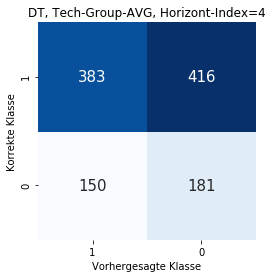

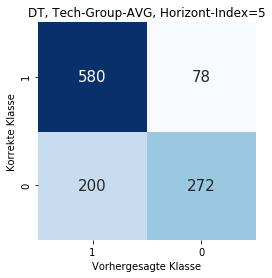

In [116]:
get_tscv_confusion_metrics(evaluation_model)

## 5.2 | Get feature importances via TSCV
- Apply time series cross validation (tscv) to calculate feature importances for a given classifier on given stock for each time horizon
- Only works for decision tree and random forest, but not for dummy classifier

In [103]:
def get_tscv_feature_importances(clf):
    """
    Calculates feature importances of given classifier for each epoch (e.g. n=10) and for each horizon (e.g. n=6) for a total of 66 combinations
    """
    announce_eval_settings()
    # 1. Load and loop over stock datasets
    for stock in [AAPL_DATA]:# TECH_GROUP:
        print("get_tscv_feature_importances() -> Stock=" + str(stock))
        
        # 2. Loop over prediction horizons
        for horizon in evaluation_horizons_indices:
            global g_horizon_index # make current horizon index accessible globally for .savefig()s
            g_horizon_index = str(horizon)
            
            # 3. Load data for stock-horizon combination. Train_size=100% because train-test splits will be executed by TSCV function
            stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename=stock, extract_features=use_feature_extraction, horizon_index=horizon, train_size=1)
            if horizon == 0:
                global g_stock_ticker # make current stock ticker index accessible globally for .savefig()s
                g_stock_ticker = str(stock_ticker)
            
            # 4. Calculate feature importances
            # Feature importances for each TSCV epoch within apply_tscv() are stored in the global variable g_feature_importances
            apply_tscv(clf, X_train, y_train, tuning=use_tuning, importances_only=True)
            # Here we calculate the average feature importances for current horizon (across all epochs). The importances for horizon-epoch combinations are covered in above .apply_tscv()
            global g_feature_importances
            # For every single feature, sum up the importances from all epochs. Afterwards, divivde by number of epochs to get the average importance of that feature
            horizon_imps_sum = [0 for epoch in range(0, len(g_feature_importances[0]))]
            for imps in g_feature_importances:
                for i in range(0, len(imps)):
                    horizon_imps_sum[i] = horizon_imps_sum[i] + imps[i]
            horizon_imps_avg = [x/len(g_feature_importances) for x in horizon_imps_sum]

            # 5. Plot horizontal bars of the average feature importances in current horizon (Top10)
            feature_ranking_indicies = np.argsort(horizon_imps_avg)
            top10_features_indices = feature_ranking_indicies[-10:]
            fig = plt.figure()
            plt.title("Einflussgrade der Features, " + str(g_classifier) + ", AAPL")
            plt.barh(y=[g_feature_names[i] for i in top10_features_indices], width=[horizon_imps_avg[i] for i in top10_features_indices])
            fig.tight_layout()
            if SAVE_FIG is True:
                plt.savefig("./Plots/" + str(g_plot_folder) + "/Top10Importances-" + str(g_classifier) + "-HorizonIndex" + str(g_horizon_index) + 
                            "-EpochsAVG-" + str(g_stock_ticker) + ".jpeg")
#             plt.close()
            # Reset feature importances for next horizon
            g_feature_importances = []
    
    return

announce_eval_settings() -> g_classifier=DT with type=<class 'sklearn.tree.tree.DecisionTreeClassifier'>
announce_eval_settings() -> g_plot_folder=Feature-Importances-TBD , VERBOSE=False
announce_eval_settings() -> evaluation_horizons_indices=[0, 1, 2, 3, 4, 5]
announce_eval_settings() -> use_feature_extraction=False, use_tuning=False
announce_eval_settings() -> SAVE_FIG=False, VERBOSE=False
get_tscv_feature_importances() -> Stock=Datasets/Kaggle_SnP500_AAPL_2013-2018.csv


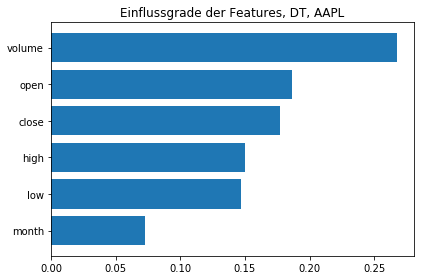

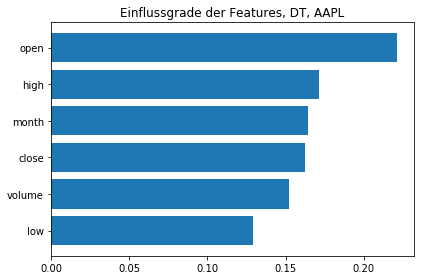

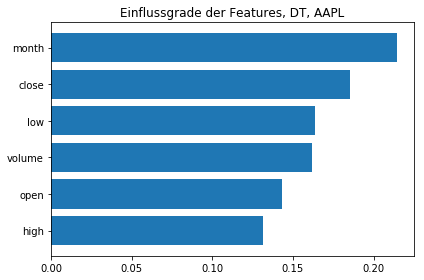

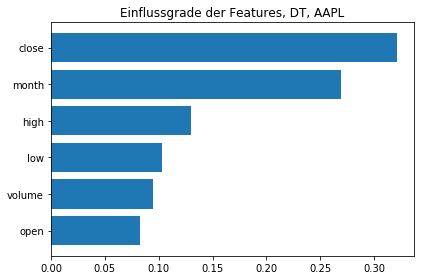

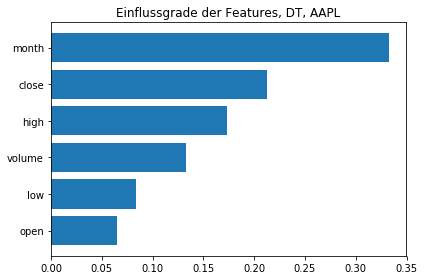

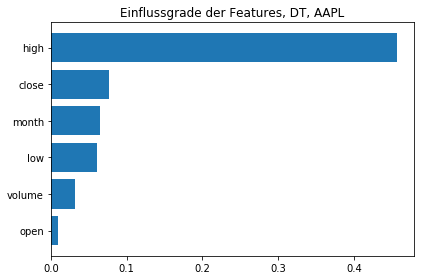

In [108]:
get_tscv_feature_importances(evaluation_model)

## 5.3 | TBD (additional result besides confusion metrics and feature importances needed?)

## 5.TBD | Decision tree hyperparameter variation example (max_depth)

In [155]:
def evaluate_dt(filename=AAPL_DATA, extract_features=True, horizon_index=2):
    """
    TBD
    """
    announce_eval_settings()
    # Load data
    stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename, extract_features, horizon_index, train_size=1)

    # Generate classifier
    clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

    # Gather all plotted series to create master plot
    plotted_Xs = []
    plotted_ys_train = []
    plotted_ys_test = []

    # Evaluate classifier for different values of selected hyperparameter
    for i in [1, 3, 5, 6, 7, 9, 11, None]:
        clf.set_params(max_depth=i)
        X_res, y_train_res, y_test_res = plot_tscv_curve(clf, "Decision Tree Treffergenauigkeiten AAPL (MAX_DEPTH=" + str(i) + ")", X_train, y_train)
        print("Mean test accuracy for MAX_DEPTH=" + str(i) + ": " + str(round(np.mean(y_test_res), 3)))
        
#         # Throw best params from 2.2 (Hyperparameter tuning) in and see if same result
#         if i == 7:
#             print("i is 7, so here we try the GRID_SEARCHED-best params: 'max_depth': 29, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 15}, achieved 58.3% acc above")
#             clf_best_params = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=29, max_features=29, min_samples_leaf=1, min_samples_split=15)
#             X_res, y_train_res, y_test_res = plot_tscv_curve(clf_best_params, "Decision Tree Treffergenauigkeiten AAPL (BEST_PARAMS)", X_train, y_train)
#             print("Best-params DT achievend ACC=" + str(i) + ": " + str(round(np.mean(y_test_res), 3)))
        
        # TBD: Use all results to make master plot
        plotted_Xs.extend([X_res])
        plotted_ys_train.extend([y_train_res])
        plotted_ys_test.extend([y_test_res])

In [ ]:
# evaluate_dt(filename=AAPL_DATA, extract_features=True, horizon_index=2)

## 5.TBD | Random forest hyperparameter variation example (n_estimators)

In [102]:
def evaluate_rf(filename=AAPL_DATA, extract_features=True, horizon_index=2):
    """
    TBD
    """
    announce_eval_settings()
    # Load data
    stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename, extract_features, horizon_index, train_size=1)

    # Generate classifier
    clf = RandomForestClassifier(n_estimators = 1, random_state=RANDOM_SEED)

    # Evaluate classifier for different values of selected hyperparameter
    for i in [1, 5, 10, 50, 100]:
        clf.set_params(n_estimators=i)
        X_res, y_train_res, y_test_res = plot_tscv_curve(clf, "Random Forest Treffergenauigkeiten AAPL (N_ESTIMATORS=" + str(i) + ")", X_train, y_train)
        print("Mean test accuracy for N_ESTIMATORS=" + str(i) + ": " + str(round(np.mean(y_test_res), 3)))
    
    # TBD: Plotting

In [ ]:
# evaluate_rf(filename=MSFT_DATA, extract_features=True, horizon_index=2)

- DT auf AAPL: Bei Variierung von MAX_DEPTH ist MAX(EXTRACTEDS)=56.2 , MAX(NO EXTRACTEDS)=53.3